Home work - feature engineering 
--- 

На лекциях 6 и 7 мы рассмотрели много приемов, как можно строить прогнозы, используя не только классические модели временных рядов. 

В этом домашнем задании я предлагаю вам проявить свободу творчества и попробовать различные методы. 
Здесь будут гайдлайны - советы, но им не обязательно следовать строго.

Вы можете приложить два ноутбука - один "черновик", где вы пробуете различные методы и делаете свои выводы. Второй - "чистовик" с оптимальной моделью, графиком и результатами.

Временной ряд №1
----

In [1]:
import pandas as pd

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
from pylab import rcParams
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import SGDRegressor

import xgboost as xgb
import statsmodels.api as sm



from cesium import datasets

df = pd.read_csv('../datatest/monthly-car-sales.csv')

Задание:
---
* Задача стоит построить прогноз на следующий год на все 12 месяцев.
* Построить признаки, основанные на времени (месяц, код), а также используя target encoding
* Построить признаки, основанные на lagged values
* Посмотреть, какие признаки работают лучше, возможно стоит скомбинировать? 
* При тестировании лучше всего пользоваться кросс-валидацией. Можно библиотекой. 

In [2]:
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df['year'] = df.index.year
df['mnth']=df.index.month
df

,Sales,year,mnth
Month,,,
1960-01-01,6550,1960,1
1960-02-01,8728,1960,2
1960-03-01,12026,1960,3
1960-04-01,14395,1960,4
1960-05-01,14587,1960,5
...,...,...,...
1968-08-01,16722,1968,8
1968-09-01,14385,1968,9
1968-10-01,21342,1968,10


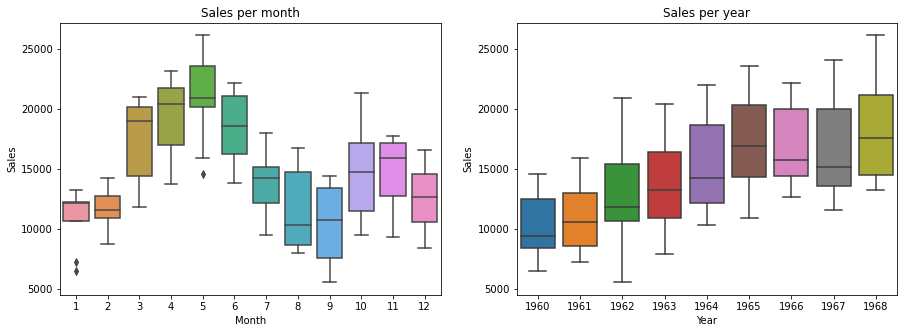

In [3]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='mnth', y='Sales', data=df)             
plt.title('Sales per month')
plt.xlabel('Month')
 
plt.subplot(1, 2, 2)
sns.boxplot(x='year', y='Sales', data=df)
plt.title('Sales per year')
plt.xlabel('Year')

plt.show()

In [4]:
metrics_result_table = pd.DataFrame(columns=['Модель', 
                                             'Комментарий',
                                             'R2_score', 
                                             'MAE']) # сюда буду складывать результаты

def modeling (model, df, features, picture, metrics, target = 'Sales'): # создаю сразу функцию, так как однотипных построений будет много 
    r_2 = []
    mae = []
    tscv = TimeSeriesSplit(n_splits=5, test_size=12) # делить на трейн и тест буду библиотекой
    
    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index] 
     
        model.fit(train[features], train[target])
        predictions = model.predict(test[features])

        mae.append(mean_absolute_error(test[target], predictions))
        r_2.append(r2_score(test[target], predictions))
        
    if picture: # рисовать график, если передаем True
        iplot(Figure(data=[Scatter(x = test.index,
                                   y = df[target],
                                   name = 'Original'),
                           Scatter(x=test.index,
                                   y = predictions,
                                   name = 'Predictions')]))

    if metrics: # отображать метрики, если передаем True
        print(f'r2_score: {np.mean(r_2)},\nMAE: {np.mean(mae)}')
    
    return np.mean(r_2), np.mean(mae) # возвращаем метрики, я их буду в результирующую табличку записывыать    


In [5]:
df1 = df.copy()
avg_vals_mnth = df1[0:-12].groupby('mnth')['Sales'].mean() # ищу среднее на трейновой части сета, что бы данняе из теста не попали сюда
df1 = df1.assign(mnth_avg=df1['mnth'].map(avg_vals_mnth)) # а соотношени делаю на веаь сет

mod_lin = LinearRegression()  
mod_rf = RandomForestRegressor()

features = ['mnth','year','mnth_avg']

a = modeling(mod_lin, df1, features, picture=True, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'just mnth_avg', a[0], a[1]]

a = modeling(mod_rf, df1, features, picture=True, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'just mnth_avg', a[0], a[1]]

metrics_result_table

,Модель,Комментарий,R2_score,MAE
0,LinearRegression,just mnth_avg,0.773714,1455.919968
1,RandomForestRegressor,just mnth_avg,0.740010,1587.544667


In [6]:
df1['rolling_mnth_2'] = df1['mnth_avg'].rolling(2, closed='left').mean()
features.append('rolling_mnth_2')
df1 = df1.where(pd.notna(df1), df1['mnth_avg'], axis=0) 

a = modeling(mod_lin, df1, ['rolling_mnth_2'], picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'rolling mnth_avg, 2', a[0], a[1]]

a = modeling(mod_rf, df1, ['rolling_mnth_2'], picture=False, metrics= False)
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'rolling mnth_avg, 2', a[0], a[1]]


In [7]:
df1['Rolling_by_mnth'] = df1.groupby('mnth')['Sales'].rolling(3, closed = 'left').mean().reset_index(0, drop = True)
features.append('Rolling_by_mnth')
df1 = df1.where(pd.notna(df1), df1['mnth_avg'], axis=0) 
 
a = modeling(mod_lin, df1, ['Rolling_by_mnth'], picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'Rolling_by_mnth', a[0], a[1]]
                                                             
a = modeling(mod_rf, df1, ['Rolling_by_mnth'], picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'Rolling_by_mnth', a[0], a[1]]
                                                             

In [8]:
df1['expanding_by_mnth'] = df1.groupby('mnth')['Sales'].expanding(center = True).mean().reset_index(0, drop = True)
features.append('expanding_by_mnth')
df1 = df1.where(pd.notna(df1), df1['mnth_avg'], axis=0) 

a = modeling(mod_lin, df1, ['expanding_by_mnth'], picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'expanding_by_mnth', a[0], a[1]]

a = modeling(mod_rf, df1, ['expanding_by_mnth'], picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'expanding_by_mnth', a[0], a[1]]

metrics_result_table.sort_values(by=['MAE'])


,Модель,Комментарий,R2_score,MAE
0,LinearRegression,just mnth_avg,0.773714,1455.919968
6,LinearRegression,expanding_by_mnth,0.760621,1481.768451
1,RandomForestRegressor,just mnth_avg,0.740010,1587.544667
7,RandomForestRegressor,expanding_by_mnth,0.667111,1765.289333
4,LinearRegression,Rolling_by_mnth,0.320454,2571.647294
5,RandomForestRegressor,Rolling_by_mnth,0.076316,3015.509698
3,RandomForestRegressor,"rolling mnth_avg, 2",-0.087206,3556.674487
2,LinearRegression,"rolling mnth_avg, 2",-0.858333,3922.066414


In [9]:
# ну и теперь пробую все вместе фичи

a = modeling(mod_lin, df1, features, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'all features', a[0], a[1]]

a = modeling(mod_rf, df1, features, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'all features', a[0], a[1]]

metrics_result_table.sort_values(by=['MAE'])

,Модель,Комментарий,R2_score,MAE
8,LinearRegression,all features,0.841881,1155.295052
0,LinearRegression,just mnth_avg,0.773714,1455.919968
9,RandomForestRegressor,all features,0.766480,1456.910833
6,LinearRegression,expanding_by_mnth,0.760621,1481.768451
1,RandomForestRegressor,just mnth_avg,0.740010,1587.544667
7,RandomForestRegressor,expanding_by_mnth,0.667111,1765.289333
4,LinearRegression,Rolling_by_mnth,0.320454,2571.647294
5,RandomForestRegressor,Rolling_by_mnth,0.076316,3015.509698
3,RandomForestRegressor,"rolling mnth_avg, 2",-0.087206,3556.674487
2,LinearRegression,"rolling mnth_avg, 2",-0.858333,3922.066414


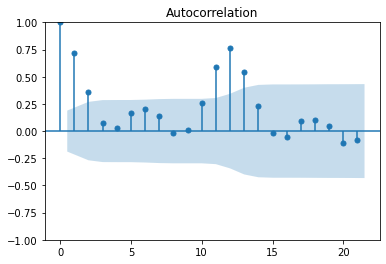

In [10]:
# дальше лаги. Что бы понять до какой стапени прошлое релевантно в прогнозировании будущего исследую автокорреляцию. 
plot_acf(df['Sales'])
plt.show();

видно, что можно выбрать 11, 12, 13 месяцев. На выберу. конечно, 12 - самая высокач автокорреляция

In [11]:
features_lag = []

for i in range(12, 25): # добавляем лаги
    df1['i-'+str(i)] = df1['Sales'].shift(i)
    features_lag.append('i-'+str(i))

# пробую применить другую модель, которая нормально работает с нулями
mod_xgb = xgb.XGBRegressor()
a = modeling(mod_xgb, df1, features_lag, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['XGBRegressor', 'lag', a[0], a[1]]


 # тут просто дропнем нулевые значения    
df1_1 = df1.copy()
df1_1.dropna(inplace=True) 

# тут заполним нулевые значения средним за соответствующий месяц 
df1_2 = df1.copy()
df1_2 = df1_2.where(pd.notna(df1_2), df1_2['mnth_avg'], axis=0) 


In [12]:
# для каждой модели на сетах с лагами, для df1_1 нули дропнуты, для df1_2 - заменены средним за месяц
a = modeling(mod_lin, df1_1, features_lag, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'lag, dropna', a[0], a[1]]

a = modeling(mod_lin, df1_2, features_lag, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'lag, NaN to mnth_avg', a[0], a[1]]


a = modeling(mod_rf, df1_1, features_lag, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'lag, dropna', a[0], a[1]]

a = modeling(mod_rf, df1_2, features_lag, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'lag, NaN to mnth_avg', a[0], a[1]]


a = modeling(mod_xgb, df1_1, features_lag, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['XGBRegressor', 'lag, dropna', a[0], a[1]]

a = modeling(mod_xgb, df1_2, features_lag, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['XGBRegressor', 'lag, NaN to mnth_avg', a[0], a[1]]


metrics_result_table.sort_values(by=['MAE'])

,Модель,Комментарий,R2_score,MAE
8,LinearRegression,all features,0.841881,1155.295052
0,LinearRegression,just mnth_avg,0.773714,1455.919968
9,RandomForestRegressor,all features,0.766480,1456.910833
6,LinearRegression,expanding_by_mnth,0.760621,1481.768451
1,RandomForestRegressor,just mnth_avg,0.740010,1587.544667
13,RandomForestRegressor,"lag, dropna",0.696955,1634.496667
15,XGBRegressor,"lag, dropna",0.636622,1722.628027
7,RandomForestRegressor,expanding_by_mnth,0.667111,1765.289333
11,LinearRegression,"lag, dropna",0.603246,1835.760075
10,XGBRegressor,lag,0.594976,1866.490544


XGBRegressor сработал лучше  всего с лагами, но значительно хуже, чем линейная регрессия

In [13]:
# на всех фичах + лагах
features = features+features_lag
a = modeling(mod_lin, df1_2, features, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['LinearRegression', 'all features + lags', a[0], a[1]]

a = modeling(mod_rf, df1_2, features, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['RandomForestRegressor', 'all features + lags', a[0], a[1]]

metrics_result_table.sort_values(by=['MAE'])

,Модель,Комментарий,R2_score,MAE
8,LinearRegression,all features,0.841881,1155.295052
0,LinearRegression,just mnth_avg,0.773714,1455.919968
9,RandomForestRegressor,all features,0.766480,1456.910833
6,LinearRegression,expanding_by_mnth,0.760621,1481.768451
17,LinearRegression,all features + lags,0.766677,1511.834793
18,RandomForestRegressor,all features + lags,0.727660,1562.148167
1,RandomForestRegressor,just mnth_avg,0.740010,1587.544667
13,RandomForestRegressor,"lag, dropna",0.696955,1634.496667
15,XGBRegressor,"lag, dropna",0.636622,1722.628027
7,RandomForestRegressor,expanding_by_mnth,0.667111,1765.289333


Ну с бубном натанцевалась:-) 

Выводы сделала следующие: 
* линейная регрессия на этом сете работает лучше
* больше фичей - лучший результат
* на фичах без лагов лучше прогноз (думаю, это из-за сезонности: у каждого месяца отдельная тенденция и данные за предыдущие n(если это не 12) мало помогают для каждого отдельного)
* expanding лучше, чем rolling
* just mnth_avg была лучшей моделью, чем модели на каждом новом признаке, но оказалась хуже, чем модель на ВСЕХ созданных признаках. 
* подход dropna оказался лучше, чем замены на среднее за месяц. Вот это для меня загадка... ВОзможно, я что-то не так сделала, потому что теоритически я потеряла часть данных (за 2 года), а прогноз оказался лучше...  


In [14]:
# тут хотела пробовать библиотеку(tsFresh и Cesium), но что-то не получилось.
# подскажете, пожалуйста, эти библиотеки стоят того ,что бы с ними разбираться?
# Они эффективные? 

from tsfresh import extract_features


In [15]:
#del df1['year']
#del df1['mnth']
#df1

In [16]:
#features = extract_features(df1, column_id="mnth", column_value="Sales")

In [17]:
#from tsfresh.feature_extraction import ComprehensiveFCParameters
#settings = ComprehensiveFCParameters()
#from tsfresh.feature_extraction import extract_features
#extract_features(df1, default_fc_parameters=settings)

Временной ряд №2
---
Колонки
* Period - дата 
* Revenue - Доход (таргет)
* Sales_quantity - количество проданных товаров. Можно использовать как признак, но только не в текущий момент времени, так как мы не знаем, сколько мы товаров продадим на момент прогноза
* Average_cost - средняя цена товара (Revenue / Sales_quantity) 

In [18]:
df2 = pd.read_csv('../datatest/month_value.csv')
df2.head()


,Period,Revenue,Sales_quantity,Average_cost
0,01.01.2015,1.601007e+07,12729.0,1257.763541
1,01.02.2015,1.580759e+07,11636.0,1358.507000
2,01.03.2015,2.204715e+07,15922.0,1384.697024
3,01.04.2015,1.881458e+07,15227.0,1235.606705
4,01.05.2015,1.402148e+07,8620.0,1626.621765


In [19]:
df2['Date']=pd.to_datetime(df2['Period'])
df2.set_index('Date',inplace=True)
df2['year'] = df2.index.year
df2['mnth']=df2.index.month
del df2['Period']
df2.head(20)



,Revenue,Sales_quantity,Average_cost,year,mnth
Date,,,,,
2015-01-01,1.601007e+07,12729.0,1257.763541,2015,1
2015-01-02,1.580759e+07,11636.0,1358.507000,2015,1
2015-01-03,2.204715e+07,15922.0,1384.697024,2015,1
2015-01-04,1.881458e+07,15227.0,1235.606705,2015,1
2015-01-05,1.402148e+07,8620.0,1626.621765,2015,1
2015-01-06,1.678393e+07,13160.0,1275.374508,2015,1
2015-01-07,1.916189e+07,17254.0,1110.576805,2015,1
2015-01-08,1.520498e+07,8642.0,1759.428870,2015,1
2015-01-09,2.060394e+07,16144.0,1276.259909,2015,1


In [20]:
metrics_result_table = pd.DataFrame(columns=['Модель', 
                                             'Комментарий',
                                             'R2_score', 
                                             'MAE']) # сюда буду складывать новые результаты

features = ['mnth','year','mnth_avg', 'Sales_quantity', 'Average_cost']


In [22]:
# вобщем, повторяю генерю то же ,что и для первого сета, но там много кода, так что немного рефакторю
df1 = df2.copy()
avg_vals_mnth = df1[0:-12].groupby('mnth')['Revenue'].mean() # ищу среднее на трейновой части сета, что бы данняе из теста не попали сюда
df1 = df1.assign(mnth_avg=df1['mnth'].map(avg_vals_mnth)) # а соотношени делаю на веаь сет

mod_linearRegr = LinearRegression() 
mod_randomForest = RandomForestRegressor()
mod_xgb = xgb.XGBRegressor()

models = [mod_linearRegr, mod_randomForest, mod_xgb] # модели все собираю в кучку, буду в цикл их засовывать 

for mod in models: # строим на исхождных фичах + среднее за месяц
    a = modeling(mod, df1, features, target = 'Revenue', picture=False, metrics= False) 
    metrics_result_table.loc[len(metrics_result_table.index)] = [str(mod), 'just mnth_avg', a[0], a[1]]


# создаю фичу сколзящее по каждому месяцу 
df1['Rolling_by_mnth'] = df1.groupby('mnth')['Revenue'].rolling(2, closed = 'left').mean().reset_index(0, drop = True)
features.append('Rolling_by_mnth')
df1 = df1.where(pd.notna(df1), df1['mnth_avg'], axis=0) 
 
for mod in models:
    a = modeling(mod, df1, ['Rolling_by_mnth'], target = 'Revenue', picture=False, metrics= False) 
    metrics_result_table.loc[len(metrics_result_table.index)] = [str(mod), 'Rolling_by_mnth', a[0], a[1]]
    
    
#    
df1['expanding_by_mnth'] = df1.groupby('mnth')['Revenue'].expanding(center = True).mean().reset_index(0, drop = True)
features.append('expanding_by_mnth')
df1 = df1.where(pd.notna(df1), df1['mnth_avg'], axis=0) 

for mod in models:
    a = modeling(mod, df1, ['expanding_by_mnth'], target = 'Revenue', picture=False, metrics= False) 
    metrics_result_table.loc[len(metrics_result_table.index)] = [str(mod), 'expanding_by_mnth', a[0], a[1]] 
    
    
# на всех добавленных фичах

for mod in models:
    a = modeling(mod, df1, features, target = 'Revenue', picture=False, metrics= False) 
    metrics_result_table.loc[len(metrics_result_table.index)] = [str(mod), 'all features', a[0], a[1]] 
    

metrics_result_table.sort_values(by=['MAE'])    


,Модель,Комментарий,R2_score,MAE
0,LinearRegression(),just mnth_avg,0.947430,1.340209e+06
9,LinearRegression(),all features,0.132816,2.982659e+06
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",just mnth_avg,0.485675,3.855447e+06
11,"XGBRegressor(base_score=0.5, booster='gbtree',...",all features,0.454884,4.146215e+06
1,RandomForestRegressor(),just mnth_avg,0.401935,4.526267e+06
10,RandomForestRegressor(),all features,0.273998,5.110815e+06
6,LinearRegression(),expanding_by_mnth,0.080315,6.546894e+06
7,RandomForestRegressor(),expanding_by_mnth,-0.285627,7.119878e+06
8,"XGBRegressor(base_score=0.5, booster='gbtree',...",expanding_by_mnth,-0.800482,8.285722e+06
3,LinearRegression(),Rolling_by_mnth,-0.680722,8.440792e+06


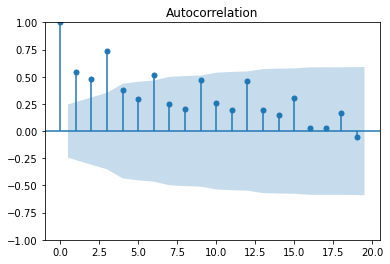

In [23]:
plot_acf(df1['Revenue'])
plt.show();

Тут интересно - хорошая автокорреляция с лагом 3

In [24]:
# добавляем лаги
features_lag = []

for i in range(12, 16): 
    df1['i-'+str(i)] = df1['Revenue'].shift(i)
    features_lag.append('i-'+str(i))

df1 = df1.where(pd.notna(df1), df1['mnth_avg'], axis=0) 
 
for mod in models:
    a = modeling(mod, df1, features_lag, target = 'Revenue', picture=False, metrics= False) 
    metrics_result_table.loc[len(metrics_result_table.index)] = [str(mod), 'lag features', a[0], a[1]] 

features = features+features_lag # добавляем все фичи в одну кучу

for mod in models:
    a = modeling(mod, df1, features, target = 'Revenue', picture=False, metrics= False) 
    metrics_result_table.loc[len(metrics_result_table.index)] = [str(mod), 'all features + lags', a[0], a[1]] 

metrics_result_table.sort_values(by=['MAE'])  

,Модель,Комментарий,R2_score,MAE
0,LinearRegression(),just mnth_avg,0.947430,1.340209e+06
9,LinearRegression(),all features,0.132816,2.982659e+06
15,LinearRegression(),all features + lags,0.097260,3.356392e+06
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",just mnth_avg,0.485675,3.855447e+06
11,"XGBRegressor(base_score=0.5, booster='gbtree',...",all features,0.454884,4.146215e+06
17,"XGBRegressor(base_score=0.5, booster='gbtree',...",all features + lags,0.377949,4.382802e+06
1,RandomForestRegressor(),just mnth_avg,0.401935,4.526267e+06
16,RandomForestRegressor(),all features + lags,0.277012,5.030198e+06
10,RandomForestRegressor(),all features,0.273998,5.110815e+06
6,LinearRegression(),expanding_by_mnth,0.080315,6.546894e+06


ну вобщем лучшей получается линейная регрессия с исходными фичами + средним за месяц. 

Задание 
---
Используя предыдущие приемы, а так же добавив еще признаки из датасета, так же построить прогноз на 3 месяца и на год вперед

In [25]:
features = ['mnth','year','mnth_avg', 'Sales_quantity', 'Average_cost']

metrics_result_table = pd.DataFrame(columns=['Модель', 
                                             'Комментарий',
                                             'R2_score', 
                                             'MAE'])

# прогнозируем на 3 месяца
r_2 = []
mae = []
tscv = TimeSeriesSplit(n_splits=5, test_size=3) 
for train_index, test_index in tscv.split(df1):
        train, test = df1.iloc[train_index], df1.iloc[test_index] 
     
        mod_linearRegr.fit(train[features], train['Revenue'])
        predictions = mod_linearRegr.predict(test[features])

        mae.append(mean_absolute_error(test['Revenue'], predictions))
        r_2.append(r2_score(test['Revenue'], predictions))
        

iplot(Figure(data=[Scatter(x = test.index,
                           y = df1['Revenue'],
                           name = 'Original'),
                   Scatter(x=test.index,
                           y = predictions,
                           name = 'Predictions')]))  
        
metrics_result_table.loc[len(metrics_result_table.index)] = ['linearRegr', '3 месяца', np.mean(r_2), np.mean(mae)] 


# прогнозируем на 12 месяцев
r_2 = []
mae = []
tscv = TimeSeriesSplit(n_splits=5, test_size=12) 
for train_index, test_index in tscv.split(df1):
        train, test = df1.iloc[train_index], df1.iloc[test_index] 
     
        mod_linearRegr.fit(train[features], train['Revenue'])
        predictions = mod_linearRegr.predict(test[features])

        mae.append(mean_absolute_error(test['Revenue'], predictions))
        r_2.append(r2_score(test['Revenue'], predictions))
        

iplot(Figure(data=[Scatter(x = test.index,
                           y = df1['Revenue'],
                           name = 'Original'),
                   Scatter(x=test.index,
                           y = predictions,
                           name = 'Predictions')]))  
        
metrics_result_table.loc[len(metrics_result_table.index)] = ['linearRegr', '12 месяцев', np.mean(r_2), np.mean(mae)] 


metrics_result_table


,Модель,Комментарий,R2_score,MAE
0,linearRegr,3 месяца,0.886275,1.697073e+06
1,linearRegr,12 месяцев,0.947430,1.340209e+06


И вот тут я тоже не поняла, почему блогноз на 3 месяца хуже, чем на год... Должно же быть наоборот. 

Наверно, у меня ошибка, но найти не смогла. 

Вообще эта работа далась сложнее предыдущих. Тема вроде и простая, а результаты какие-то не очень... 
